# Comparing hydrological hindcasts to an ESP forecast

This notebook shows how to use climatological weather to perform a Climatology-based Extended Streamflow Prediction (ESP) forecast. Then using the same initial states, uses the CaSPar archived weather forecasts to generate streamflow hindcasts over the same period. It is thus possible to compare both approaches.

CaSPAr (Canadian Surface Prediction Archive) is an archive of historical ECCC forecasts developed by Juliane Mai at the University of Waterloo, Canada. More details on CaSPAr can be found here https://caspar-data.ca/.

Mai, J., Kornelsen, K.C., Tolson, B.A., Fortin, V., Gasset, N., Bouhemhem, D., Schäfer, D., Leahy, M., Anctil, F. and Coulibaly, P., 2020. The Canadian Surface Prediction Archive (CaSPAr): A Platform to Enhance Environmental Modeling in Canada and Globally. Bulletin of the American Meteorological Society, 101(3), pp.E341-E356.

In [1]:
%matplotlib inline
# This entire section is cookie-cutter template to allow calling the servers and instantiating the connection
# to the WPS server. Do not modify this block.
import datetime as dt

import matplotlib.pyplot as plt
import xarray as xr
from clisops.core import average, subset

from ravenpy import Emulator
from ravenpy.extractors.new_config.forecasts import get_CASPAR_dataset
from ravenpy.new_config import commands as rc
from ravenpy.new_config.emulators import GR4JCN
from ravenpy.utilities.new_config import forecasting

## Hindcasting - Setting up the warm-up file

Here we tell the model that we want to forecast over the Salmon River catchment and provide its properties (area, lat/long, elevation). We will run it using the GR4JCN hydrological model and have provided some parameters. Other information on the forecast conditions is provided. Thr first step is to generate a hotstart file to prepare the model to generate forecasts.

In [2]:
# Define the warmup period dates
start_date_wu = dt.datetime(2010, 1, 1)
end_date_wu = dt.datetime(2018, 5, 31)

# Define the catchment contour. Here we use the Salmon River file we previously generated using the Delineator
# in Tutorial Notebook 01.
basin_contour = "salmon_river.geojson"

# Define some of the catchment properties. Could also be replaced by a call to the properties WPS as in
# the Tutorial Notebook 02.
hru = {}
hru = dict(
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    hru_type="land",
)

# Observed weather data for the Salmon river. We extracted this using Tutorial Notebook 03 and the
# salmon_river.geojson file as the contour.
ts = "ERA5_weather_data_Salmon.nc"

# Set alternative names for netCDF variables
alt_names = {
    "TEMP_MIN": "tmin",
    "TEMP_MAX": "tmax",
    "PRECIP": "pr",
}

# Data types to extract from netCDF
data_type = ["TEMP_MAX", "TEMP_MIN", "PRECIP"]
data_kwds = {
    "ALL": {
        "elevation": hru["elevation"],
        "Latitude": hru["latitude"],
        "Longitude": hru["longitude"],
    },
}

# Model configuration
model_config_warmup = GR4JCN(
    params=[0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    Gauge=[
        rc.Gauge.from_nc(
            ts, data_type=data_type, alt_names=alt_names, data_kwds=data_kwds
        )
    ],
    HRUs=[hru],
    StartDate=start_date_wu,
    EndDate=end_date_wu,
    RunName="ESP_vs_NWP_warmup",
    GlobalParameter={"AVG_ANNUAL_RUNOFF": 208.480},
)

# Run the model and get the outputs.
out1 = Emulator(config=model_config_warmup).run()

# Extract the path to the final states file that will be used as the next initial states
hotstart = out1.files["solution"]

/home/david/src/RavenPy/ravenpy/ravenpy.py:289: RavenWarning: The required parameter RAIN_ICEPT_PCT for vegetation class VEG_ALL was autogenerated with value 0.120000
  warn(msg, category=RavenWarning)
/home/david/src/RavenPy/ravenpy/ravenpy.py:289: RavenWarning: The required parameter SNOW_ICEPT_PCT for vegetation class VEG_ALL was autogenerated with value 0.100000
  warn(msg, category=RavenWarning)
/home/david/src/RavenPy/ravenpy/ravenpy.py:289: RavenWarning: The required parameter RAIN_ICEPT_PCT for vegetation class VEG_WATER was autogenerated with value 0.120000
  warn(msg, category=RavenWarning)
/home/david/src/RavenPy/ravenpy/ravenpy.py:289: RavenWarning: The required parameter SNOW_ICEPT_PCT for vegetation class VEG_WATER was autogenerated with value 0.100000
  warn(msg, category=RavenWarning)
/home/david/src/RavenPy/ravenpy/ravenpy.py:289: RavenWarning: Because no processes with CANOPY_SNOW variable have been specified, all snow interception will be directly moved to the atmosp

# Hindcasting using Climatological Ensemble Streamflow Prediction (ESP)
Now that we have the hotstart file ready to go, we can configure our model for forecasting in climatology ESP mode:

In [3]:
%%capture --no-display
# Adding this to avoid spamming warning messages for overwriting files.

# Date of the hindcast
hdate = dt.datetime(2018, 6, 1)

# Duration of the hindcast, in days
duration = 7

# Build a new model config:
# Model configuration
model_config_ESP = GR4JCN(
    params=[0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    Gauge=[
        rc.Gauge.from_nc(
            ts, data_type=data_type, alt_names=alt_names, data_kwds=data_kwds
        )
    ],
    HRUs=[hru],
    StartDate=hdate,
    Duration=duration,
    RunName="ESP_vs_NWP_ESPfcst",
    GlobalParameter={"AVG_ANNUAL_RUNOFF": 208.480},
)

# Set the initial states of this new config to the correct values, i.e. the end of the previous forecast.
model_config_ESP = model_config_ESP.set_solution(hotstart)

# Simulate the climatological ESP:
ESP_sims = forecasting.climatology_esp(config=model_config_ESP)

# Show the results in an xarray dataset, ready to use:
ESP_sims.hydrograph

<xarray.Dataset>
Dimensions:     (member: 40, time: 8, nbasins: 1)
Coordinates:
  * member      (member) int64 1981 1982 1983 1984 1985 ... 2017 2018 2019 2020
  * time        (time) datetime64[ns] 2018-05-31 2018-06-01 ... 2018-06-07
    basin_name  (nbasins) object 'sub_001'
Dimensions without coordinates: nbasins
Data variables:
    precip      (member, time) float64 nan 2.197 0.0 ... 0.3967 0.7833 3.911
    q_sim       (member, time, nbasins) float64 5.773 5.746 5.718 ... 5.7 5.689
    q_obs       (member, time, nbasins) float64 nan nan nan nan ... nan nan nan
    q_in        (member, time, nbasins) float64 nan nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    featureType:  timeSeries
    history:      Created by Raven
    description:  Standard Output

We have now run the hindcast using Climatological ESP and retrieved the results. Let's take a look at the resulting forecast.

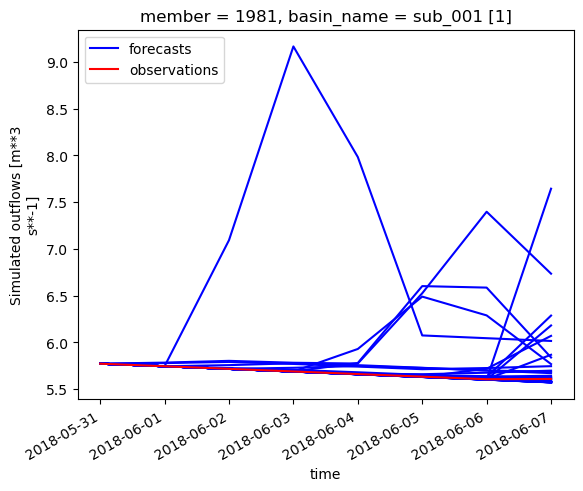

In [4]:
# Invent an observation so we can compute metrics later, and display as Qobs here. TODO: Add real streamflow data.
qq = ESP_sims.hydrograph.q_sim[0, :, 0]

# This is to be replaced with a call to the forecast graphing WPS as soon as merged.
# model.q_sim.plot.line("b", x="time")
ESP_sims.hydrograph.q_sim[:, :, 0].plot.line("b", x="time", add_legend=False)
ESP_sims.hydrograph.q_sim[1, :, 0].plot.line("b", x="time", label="forecasts")
qq.plot.line("r", x="time", label="observations")
plt.legend(loc="upper left")
plt.show()

## Hindcasting using archived weather forecasts from a weather forecast model

In this next part, we will use the CaSPAr dataset (archived weather forecasts from Environment and Climate Change Canada) to forecast flows on the same period using the same hotstart file.

In [5]:
%%capture --no-display

# Get the Forecast data from GEPS via CASPAR.
# Take an extra day to ensure time-shift doesn't remove a part of our day
ts_hindcast, _ = get_CASPAR_dataset("GEPS", hdate - dt.timedelta(days=1))

# Subset the data for the region of interest and take the mean to get a single vector
with xr.set_options(keep_attrs=True):
    ts_subset = subset.subset_shape(ts_hindcast, "salmon_river.geojson").mean(
        dim=("rlat", "rlon")
    )

ts_subset = ts_subset.resample(time="6H").nearest(
    tolerance="1H"
)  # To make the timesteps identical accross the entire duration

# We need to write the hindcast data as a file for Raven to be able to access it.
fname = "/tmp/hindcast.nc"
ts_subset.to_netcdf(fname)

# We need to adjust the data_type and alt_names according to the data in the forecast:
# Set alternative names for netCDF variables
alt_names = {
    "TEMP_AVE": "tas",
    "PRECIP": "pr",
}

# Data types to extract from netCDF
data_type = ["TEMP_AVE", "PRECIP"]

# We will need to reuse this for GR4J. Update according to your needs. For example, here we will also pass
# the catchment latitude and longitude as our CaSPAr data has been averaged at the catchment scale.
# We also need to tell the model to deaccumulate the precipitation and shift it in time by 6 hours for our
# catchment (UTC timezones):
data_kwds = {
    "ALL": {
        "elevation": hru["elevation"],
        "Latitude": hru["latitude"],
        "Longitude": hru["longitude"],
    },
    "PRECIP": {
        "Deaccumulate": True,
        "TimeShift": -0.25,
    },
    "TEMP_AVE": {
        "TimeShift": -0.25,
    },
}

# Model configuration for forecasting, including correct start date and forecast duration
model_config_fcst = GR4JCN(
    params=[0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    Gauge=[
        rc.Gauge.from_nc(
            fname, data_type=data_type, alt_names=alt_names, data_kwds=data_kwds
        )
    ],
    HRUs=[hru],
    StartDate=hdate,
    Duration=duration,
    RunName="NB12_forecast_run",
    GlobalParameter={"AVG_ANNUAL_RUNOFF": 208.480},
)

# Update the initial states
model_config_fcst = model_config_fcst.set_solution(hotstart)

# Generate the hindcast by providing all necessary information to generate virtual stations representing
# the forecast members
hindcast_sims = forecasting.hindcast_from_meteo_forecast(
    model_config_fcst,
    forecast=fname,
    path="/tmp/run_results_ESP_vs_NWP_NWP",
    overwrite=True,
    # We also need to provide the necessary information to create gauges inside the forecasting model:
    data_kwds=data_kwds,
    data_type=data_type,
    alt_names=alt_names,
)

# Display the hydrographs
display(hindcast_sims.hydrograph)

<xarray.Dataset>
Dimensions:     (time: 8, member: 20, nbasins: 1)
Coordinates:
  * time        (time) datetime64[ns] 2018-05-31 2018-06-01 ... 2018-06-07
    basin_name  (nbasins) object 'sub_001'
Dimensions without coordinates: member, nbasins
Data variables:
    precip      (member, time) float64 nan 0.01962 0.05464 ... 82.05 172.5 176.0
    q_sim       (member, time, nbasins) float64 5.773 5.746 ... 197.7 740.7
    q_obs       (member, time, nbasins) float64 nan nan nan nan ... nan nan nan
    q_in        (member, time, nbasins) float64 nan nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    featureType:  timeSeries
    history:      Created by Raven
    description:  Standard Output

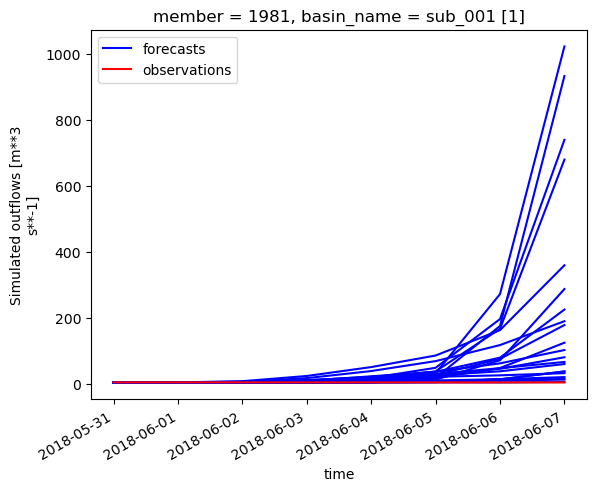

In [6]:
hindcast_sims.hydrograph.q_sim[:, :, 0].plot.line("b", x="time", add_legend=False)
hindcast_sims.hydrograph.q_sim[1, :, 0].plot.line("b", x="time", label="forecasts")
qq.plot.line("r", x="time", label="observations")
plt.legend(loc="upper left")
plt.show()

The model has run in forecast mode and we can now easily compare results:

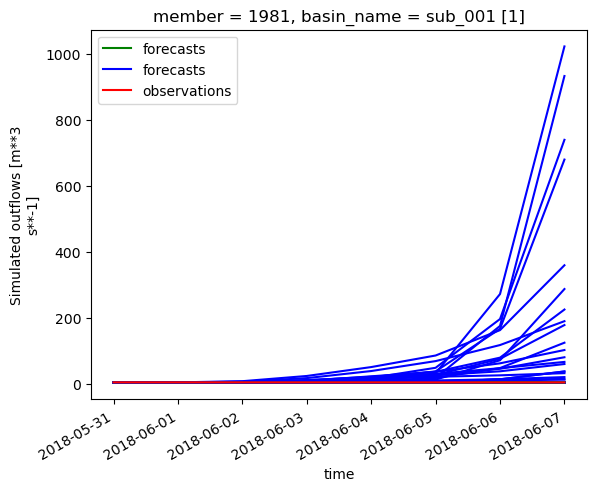

In [7]:
hindcast_sims.hydrograph.q_sim[:, :, 0].plot.line("b", x="time", add_legend=False)
ESP_sims.hydrograph.q_sim[:, :, 0].plot.line("b", x="time", add_legend=False)
ESP_sims.hydrograph.q_sim[1, :, 0].plot.line("g", x="time", label="forecasts")
hindcast_sims.hydrograph.q_sim[1, :, 0].plot.line("b", x="time", label="forecasts")
qq.plot.line("r", x="time", label="observations")
plt.legend(loc="upper left")
plt.show()